In [52]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

In [53]:
# Load dataset
data = pd.read_csv('Tweets.csv')

In [54]:
data.dropna(subset=['text'], inplace=True)

In [55]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [56]:
import matplotlib.pyplot as plt

In [57]:
sentiment_counts = data['sentiment'].value_counts()

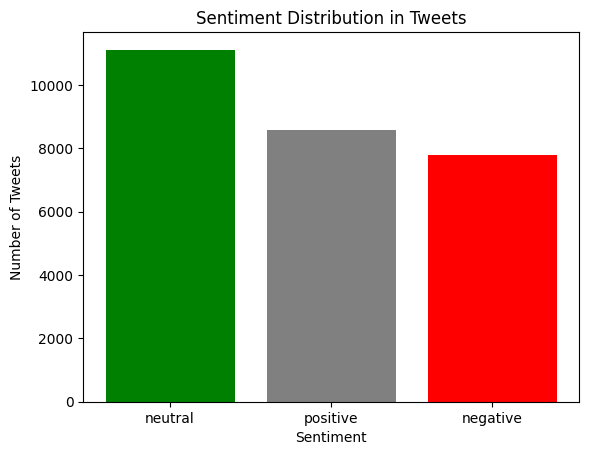

In [58]:
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['green', 'gray', 'red'])
plt.title('Sentiment Distribution in Tweets')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

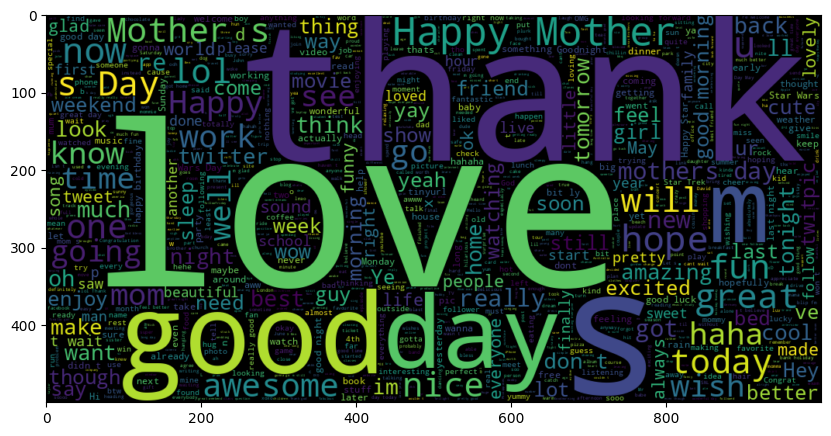

In [59]:
from wordcloud import WordCloud

plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000 , width = 1000 , height = 500).generate(" ".join(data[data.sentiment == 'positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

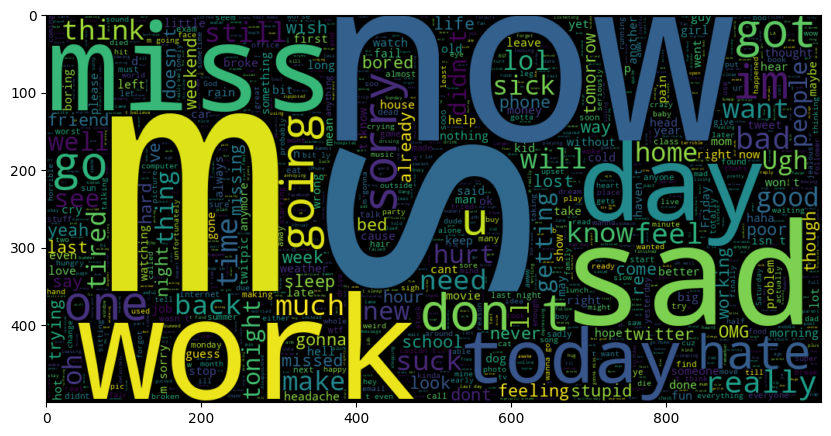

In [60]:
from wordcloud import WordCloud

plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000 , width = 1000 , height = 500).generate(" ".join(data[data.sentiment == 'negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

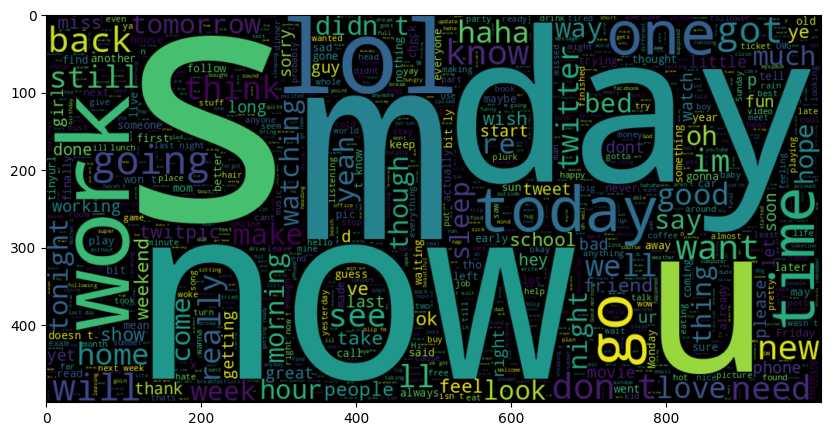

In [61]:
from wordcloud import WordCloud

plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000 , width = 1000 , height = 500).generate(" ".join(data[data.sentiment == 'neutral'].text))
plt.imshow(wc , interpolation = 'bilinear')

# New Section

In [62]:
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [64]:
texts = data['text'].values
sentiments = {'negative': 0, 'neutral': 1, 'positive': 2}
labels = data['sentiment'].map(sentiments).values

In [65]:
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [66]:
max_len = 128
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, max_len)
test_dataset = TweetDataset(test_texts, test_labels, tokenizer, max_len)

In [67]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [68]:
num_epochs = 5
learning_rates = [5e-5, 3e-5, 2e-5, 1e-5]  # List of learning rates
warmup_steps = 0.1  # Percentage of total training steps for warmup
total_steps = len(train_loader) * num_epochs
optimizer = AdamW(model.parameters(), lr=learning_rates[0])
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(warmup_steps*total_steps), num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [69]:
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    pbar = tqdm(train_loader, position=0, leave=True)
    for step, batch in enumerate(pbar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Optional: Gradient clipping
        optimizer.step()
        scheduler.step()
        pbar.set_description(f'Epoch {epoch + 1}/{num_epochs}, Average Train Loss: {total_train_loss / (step + 1):.4f}')
    train_losses.append(total_train_loss / len(train_loader))

    # Validation loop
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_val_loss += loss.item()
    val_losses.append(total_val_loss / len(test_loader))

  0%|          | 0/1374 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Epoch 5/5, Average Train Loss: 0.0712: 100%|██████████| 137

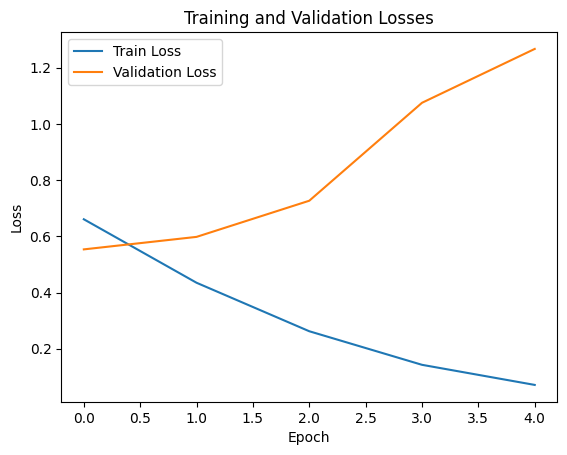

In [70]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [71]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad(), tqdm(total=len(test_loader), position=0, leave=True) as pbar:
    probabilities = []
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())
        pbar.update(1)
        probabilities.extend(F.softmax(logits, dim=1).cpu().numpy())

100%|██████████| 344/344 [00:45<00:00,  7.61it/s]


In [72]:
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy:.4f}')

# Classification report
target_names = list(sentiments.keys())
print('Classification Report:')
print(classification_report(true_labels, predictions, target_names=target_names))

Accuracy: 0.7824
Classification Report:
              precision    recall  f1-score   support

    negative       0.77      0.77      0.77      1572
     neutral       0.75      0.76      0.75      2236
    positive       0.84      0.83      0.83      1688

    accuracy                           0.78      5496
   macro avg       0.79      0.79      0.79      5496
weighted avg       0.78      0.78      0.78      5496



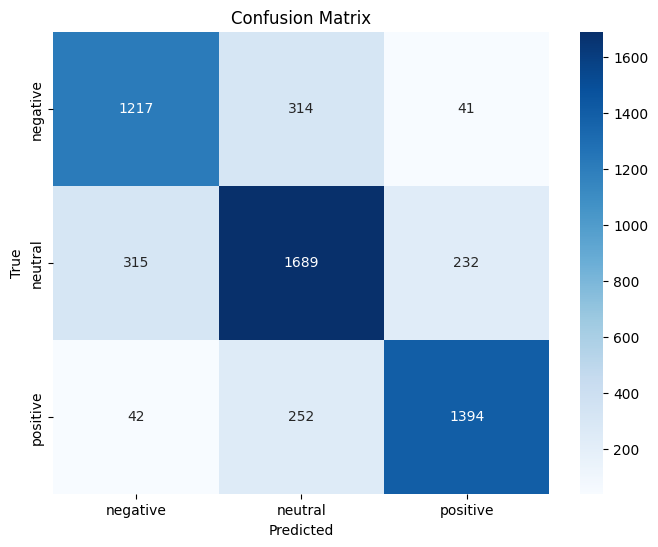

In [73]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=sentiments.keys(), yticklabels=sentiments.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


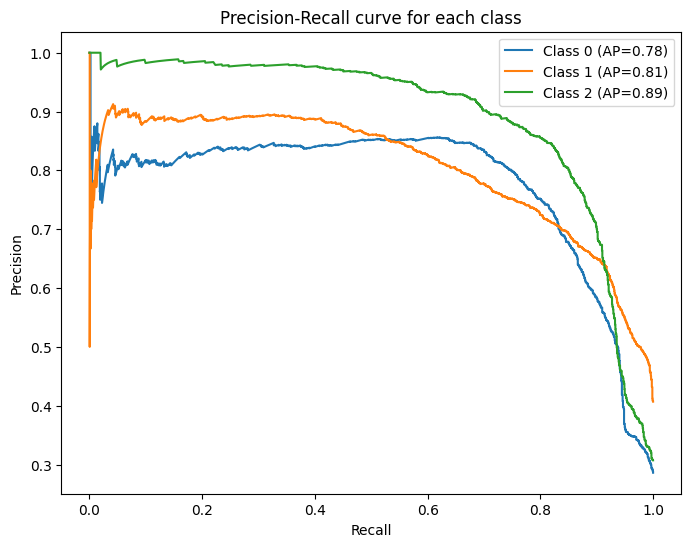

In [80]:
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score

# Model evaluation loop
model.eval()
with torch.no_grad():
    probabilities = []
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities.extend(F.softmax(logits, dim=1).cpu().numpy())

# Convert probabilities to numpy array
probabilities = np.array(probabilities)

# Convert true_labels to integers
true_labels_int = np.array(true_labels)

# Initialize empty lists to store precision and recall values for each class
precisions = []
recalls = []
average_precisions = []

# Calculate precision and recall for each class
for i in range(len(sentiments)):
    precision, recall, _ = precision_recall_curve(true_labels_int == i, probabilities[:, i])
    average_precision = average_precision_score(true_labels_int == i, probabilities[:, i])
    precisions.append(precision)
    recalls.append(recall)
    average_precisions.append(average_precision)

# Plot the Precision-Recall curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(sentiments)):
    plt.plot(recalls[i], precisions[i], label='Class {} (AP={:.2f})'.format(i, average_precisions[i]))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve for each class')
plt.legend()
plt.show()